In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

In [125]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

In [2]:
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


In [15]:
# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [3]:
# load the test image
img_name = '1.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

resnet50 prediction on 1.jpg
0.317 -> coast
0.193 -> beach
0.141 -> ocean
0.076 -> field/wild
0.056 -> boardwalk


In [9]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import glob
import torch.nn as nn
import os.path as osp
import torchvision
import matplotlib.pyplot as plt



import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
#import rotateImage
import cv2
import numpy as np
#import split_folders
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
from random import choice
from collections import OrderedDict

In [5]:
the_model = torch.load('/content/drive/My Drive/00_openvino/resnet50_places365.pth.tar')

In [6]:
type(the_model)

dict

In [7]:
print(the_model.keys())

dict_keys(['state_dict', 'epoch', 'arch', 'best_prec1'])


In [8]:
the_model['epoch']

66

In [9]:
arch = the_model['arch']

In [10]:
the_model['best_prec1']

55.57260273972603

In [118]:
import torchvision.models as models

def load_model(checkpoint_path):
  arch='resnet50'
  model = models.__dict__[arch](num_classes=365)
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
  state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  model.load_state_dict(state_dict)
  model.eval()

  net = torchvision.models.resnet50(pretrained = True)
  net.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=365))
  net.fc = nn.Sequential(*list(net.fc)+[nn.Softmax(1)])

  # model = models.__dict__[arch](num_classes=365)
  # checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

  # state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  # model.load_state_dict(state_dict)

  print(model.fc)
  # model.fc = nn.Sequential(*list(model.fc)+[nn.Softmax(1)])
  # model = nn.Sequential(model.fc,nn.Softmax())
  # model.fc = nn.Sequential(
  #   model.fc,
  #   nn.Softmax())
  model.fc =  nn.Sequential(*model.fc, nn.Softmax())
#nn.Sequential(OrderedDict([(model.fc),("softamx_layer", nn.Softmax())]))

  for param, x in model.named_parameters():
      x.requires_grad= False

  # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  # model = model.to(device)

  return model

In [139]:
def load_model_raushan(checkpoint_path):
  chpt = torch.load(checkpoint_path)
  net = torchvision.models.resnet50(pretrained=True)
  fc = nn.Sequential(OrderedDict([
    ("dropout", nn.Dropout(0.4)),
    ("out", nn.Linear(2048, 365))]))
  net.fc = fc

  for param, x in net.named_parameters():
    if param.startswith("fc.out"):
        x.requires_grad = True
    else:
        x.requires_grad = False

  # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #net.class_to_idx = classes
  # net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
  # net.class_to_idx = chpt['class_to_idx']
    
     
    
  net.load_state_dict(chpt['state_dict'], strict=False)
    
  return net

In [140]:
the_model = load_model_raushan('/content/drive/My Drive/00_openvino/resnet50_places365.pth.tar')

In [141]:
type(the_model)

torchvision.models.resnet.ResNet

In [142]:
print(the_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
img_name = '12.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)

In [71]:
img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

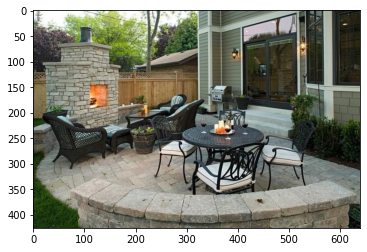

In [72]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [143]:
model_output = the_model(input_img)
print(model_output)
# [1,365]

RuntimeError: ignored

In [107]:
# forward pass
# logit = the_model.forward(input_img)
# print(logit)
# h_x_1 = F.softmax(logit, 1).data.squeeze()
probs_1, idx_1 = model_output.sort(0, True)
# print(idx)

print('{} prediction on {}'.format('resnet50',img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs_1[i], classes[idx_1[i]]))


### ------------------------- without sequential--------------------------
# resnet50 prediction on 12.jpg
# 0.685 -> patio
# 0.240 -> restaurant_patio
# 0.019 -> beer_garden
# 0.010 -> courtyard
# 0.010 -> porch ###

resnet50 prediction on 12.jpg


TypeError: ignored

In [ ]:
for name, param in the_model.named_parameters():
    print(name, ':', param.requires_grad)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')
onnx_path =  "/content/drive/My Drive/00_openvino/resnet50_places365.onnx"

torch.onnx.export(the_model, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

In [138]:
dummy_input = torch.randn(1, 3, 256, 256)
onnx_path =  "/content/drive/My Drive/00_openvino/resnet50_places365_output_layer.onnx"

torch.onnx.export(the_model, dummy_input, onnx_path, verbose=False)
print('Model exported to ' + onnx_path)

Model exported to /content/drive/My Drive/00_openvino/resnet50_places365_output_layer.onnx
